In [1]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()
chat_model=ChatGroq(model="llama3-8b-8192")

In [2]:
from youtube_transcript_api import YouTubeTranscriptApi

def fetch_transcript(video_id: str):
    ytt_api = YouTubeTranscriptApi()
    fetched_transcript = ytt_api.fetch(video_id)

    # Combine all snippet texts into one string
    combined_text = " ".join(snippet.text for snippet in fetched_transcript)
    return combined_text

In [3]:
video_id = "PVa2_hl2EqE"
transcript = fetch_transcript(video_id)
transcript

'Hello everyone. I\'m back with one more story for you all. A proud parrot. Once there lived a parrot in a big tree. He was proud of his beautiful green wings and red beak. He saw a crow and thought how ugly the crow wings are. Then the crow replied, "Though I am ugly, my wings will help me to fly high for longer distances." And no one will try to catch me. Do you know that the parrot moved closer to the crow and showed his beautiful feathers to the crow? Just then, a man arrived with a cage to catch the pirate. The man caught the parrot and kept it in the cage. Moral of the story, don\'t be proud of yourself. See you again with one more story. Thank you.'

In [4]:
from typing import Any

# Step 2: Title Generator Node
def generate_blog_title(transcript: str) -> str:
    """
    Generates an engaging blog-style title from a transcript.

    Args:
        transcript (str): The raw transcript text.
        chat_model (Any): An LLM client instance with an `.invoke(prompt)` method.

    Returns:
        str: The generated blog title.
    """
    prompt = f"""Generate an engaging blog-style title for this transcript:

Transcript:
{transcript}
"""
    response = chat_model.invoke(prompt).content
    return response # type: ignore


In [ ]:
blog_title = generate_blog_title(transcript)

In [5]:
# Step 3: Content Generator Node
def generate_blog_content(transcript: str) -> str:
    """
    Expands a transcript into a well-structured blog article.

    Args:
        transcript (str): The raw transcript text.
        llm_client (Any): An LLM client instance with a `.generate(prompt)` method.

    Returns:
        str: The generated blog article with intro, body, and conclusion.
    """
    prompt = f"""Expand this transcript into a well-structured blog article 
with an introduction, body, and conclusion:

Transcript:
{transcript}
"""
    response = chat_model.invoke(prompt).content
    return response # type: ignore


In [ ]:
blog_content = generate_blog_content(transcript)

In [6]:
def merge_blog_title_and_content(title: str, content: str) -> dict:
    """
    Combines a generated blog title and blog content into a dictionary.

    Args:
        title (str): The blog title.
        content (str): The blog body (intro, body, conclusion).

    Returns:
        dict: A dictionary with 'title' and 'content' keys.
    """
    return {
        "title": title.strip(),
        "content": content.strip()
    }


In [ ]:
final_blog = merge_blog_title_and_content(blog_title,blog_content)

In [7]:
final_blog = {
  "title": "The Battlefield Within: Applying Arjuna’s Dilemma to Modern Decision-Making",
  "content": (
        "In the moments before battle, Arjuna wrestled with doubt and duty. "
        "His struggle mirrors ours when we face tough choices at work or home. "
        "Discover three practical steps drawn from Bhagavad-Gītā 2.11–2.30 that help you "
        "overcome paralysis by analysis and act with confidence."
    )
}

In [ ]:
import os
import requests

def publish_blog_to_facebook(final_blog: dict) -> dict:
    """
    Publishes a blog post to a Facebook Page feed, then retrieves its id, message, and created_time.
    
    Environment Variables:
        FACEBOOK_PAGE_ID            – the target Page ID
        FACEBOOK_PAGE_TOKEN         – a valid Page access token
        FACEBOOK_GRAPH_API_VERSION  – Graph API version (default: v16.0)
    
    Args:
        final_blog: A dict with keys "title" and "content".
    
    Returns:
        A dict containing the published post's id, message, and created_time.
    
    Raises:
        RuntimeError: If either the POST or GET request fails.
    """
    page_id            = os.getenv("FACEBOOK_PAGE_ID")
    page_access_token  = os.getenv("FACEBOOK_PAGE_TOKEN")
    graph_api_version  = os.getenv("FACEBOOK_GRAPH_API_VERSION", "v16.0")

    if not page_id or not page_access_token:
        raise RuntimeError("Missing FACEBOOK_PAGE_ID or FACEBOOK_PAGE_TOKEN environment variable")

    message_text = f"{final_blog.get('title', '')}\n\n{final_blog.get('content', '')}"

    post_url = f"https://graph.facebook.com/{graph_api_version}/{page_id}/feed"
    post_params = {
        "message": message_text,
        "access_token": page_access_token
    }
    post_resp = requests.post(post_url, data=post_params)
    if not post_resp.ok:
        raise RuntimeError(f"Failed to publish post: {post_resp.text}")
    post_id = post_resp.json().get("id")
    if not post_id:
        raise RuntimeError(f"No post ID returned: {post_resp.text}")

    # 2) GET /{post_id}?fields=id,message,created_time
    get_url = f"https://graph.facebook.com/{graph_api_version}/{post_id}"
    get_params = {
        "fields": "id,message,created_time",
        "access_token": page_access_token
    }
    get_resp = requests.get(get_url, params=get_params)
    if not get_resp.ok:
        raise RuntimeError(f"Failed to retrieve post data: {get_resp.text}")

    return get_resp.json()


In [9]:
post_info = publish_blog_to_facebook(final_blog)


In [10]:
post_info

{'id': '756801380851537_122097779288990927',
 'message': 'The Battlefield Within: Applying Arjuna’s Dilemma to Modern Decision-Making\n\nIn the moments before battle, Arjuna wrestled with doubt and duty. His struggle mirrors ours when we face tough choices at work or home. Discover three practical steps drawn from Bhagavad-Gītā 2.11–2.30 that help you overcome paralysis by analysis and act with confidence.',
 'created_time': '2025-08-22T07:12:56+0000'}

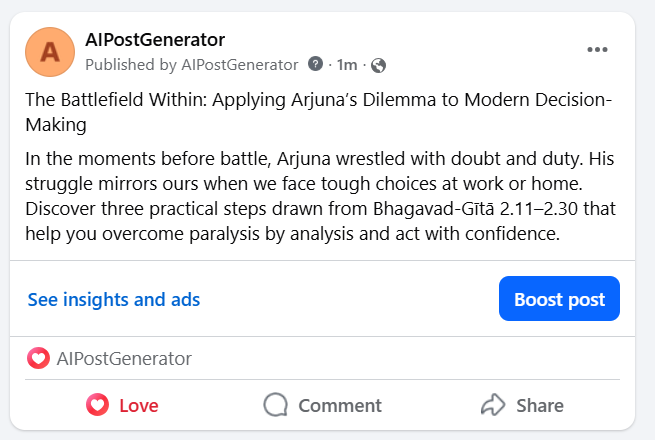

In [ ]:
import os
import requests
from typing import Dict

def publish_blog_to_instagram(state: Dict) -> Dict:
    """
    Publishes a blog post to Instagram by creating a media object and publishing it.
    Reads 'blog' and 'image_url' from state, then updates 'finalpost'.
    
    Environment Variables:
        INSTAGRAM_PAGE_ID           – the Instagram Business Account ID (not user ID!)
        FACEBOOK_PAGE_TOKEN         – a valid Page access token (with instagram_basic, pages_show_list, instagram_content_publish)
        FACEBOOK_GRAPH_API_VERSION  – Graph API version (default: v16.0)
    """
    ig_account_id     = os.getenv("INSTAGRAM_PAGE_ID")
    access_token      = os.getenv("FACEBOOK_PAGE_TOKEN")
    graph_api_version = os.getenv("FACEBOOK_GRAPH_API_VERSION", "v16.0")

    if not ig_account_id or not access_token:
        raise RuntimeError("Missing INSTAGRAM_PAGE_ID or FACEBOOK_PAGE_TOKEN environment variables")

    blog = state.get("blog", {})
    image_url = state.get("image_url", "")

    if not blog:
        raise ValueError("No blog found in state to publish")
    if not image_url:
        raise ValueError("No image_url found in state for Instagram post")

    caption_text = f"{blog.get('title', '')}\n\n{blog.get('content', '')}"

    # Step 1: Create media object
    media_url = f"https://graph.facebook.com/{graph_api_version}/{ig_account_id}/media"
    media_params = {
        "image_url": image_url,
        "caption": caption_text,
        "access_token": access_token
    }
    media_resp = requests.post(media_url, data=media_params)
    if not media_resp.ok:
        raise RuntimeError(f"Failed to create Instagram media: {media_resp.text}")
    media_id = media_resp.json().get("id")
    if not media_id:
        raise RuntimeError(f"No media ID returned: {media_resp.text}")

    # Step 2: Publish the media object
    publish_url = f"https://graph.facebook.com/{graph_api_version}/{ig_account_id}/media_publish"
    publish_params = {
        "creation_id": media_id,
        "access_token": access_token
    }
    publish_resp = requests.post(publish_url, data=publish_params)
    if not publish_resp.ok:
        raise RuntimeError(f"Failed to publish Instagram post: {publish_resp.text}")

    # Return updated state with finalpost
    return {
        "finalpost": publish_resp.json()
    }
